In [2]:
import pickle
import numpy as np

In [3]:
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [4]:
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [5]:
type(test_data)

list

In [6]:
type(train_data)

list

In [7]:
len(train_data)

10000

In [8]:
len(test_data)

1000

In [9]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [10]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [11]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [12]:
''.join(train_data[0][2])

'no'

In [13]:
all_data = test_data + train_data

In [14]:
len(all_data)

11000

In [15]:
vocab = set()
for story,question,answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [16]:
vocab.add('no')

In [17]:
vocab.add('yes')

In [18]:
vocab_len = len(vocab) + 1

In [19]:
all_story_lens = [len(data[0]) for data in all_data]

In [20]:
max_story_len = max(all_story_lens)

In [21]:
max_question_len = max([len(data[1]) for data in all_data])

In [22]:
max_question_len

6

In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

Using TensorFlow backend.


In [24]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [25]:
train_story_text = []
train_question_text = []
train_answer_text = []

In [26]:
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer_text.append(answer)

In [27]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [28]:
def vectorize_stories(data, word_index = tokenizer.word_index,max_story_len= max_story_len,max_question_len=max_question_len ):
    # Stories = X
    X = []
    # Questions Xq
    Xq = []
    # Correct Answer (yes/no)
    Y = []
    
    for story,query,answer in data:
        # for each story
        # [23,14,...]
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X,maxlen = max_story_len),pad_sequences(Xq,maxlen = max_question_len),np.array(Y))
    

In [29]:
inputs_train, queries_train, answer_train = vectorize_stories(train_data)

In [30]:
inputs_test, queries_test, answer_test = vectorize_stories(test_data)

In [31]:
inputs_test

array([[ 0,  0,  0, ..., 29, 36, 12],
       [ 0,  0,  0, ..., 29, 11, 12],
       [ 0,  0,  0, ..., 29, 11, 12],
       ...,
       [ 0,  0,  0, ..., 29, 16, 12],
       [ 0,  0,  0, ..., 29, 11, 12],
       [ 0,  0,  0, ..., 16, 23, 12]])

In [32]:
answer_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [33]:
tokenizer.word_index['yes']

2

In [34]:
tokenizer.word_index['no']

34

In [35]:
sum(answer_test)

array([  0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 503.,   0.,   0.,   0.])

In [36]:
from keras.models import Sequential,Model

In [37]:
from keras.layers.embeddings import Embedding

In [38]:
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [51]:
# PLACEHOLDER shape  = (max_story_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [52]:
# vocab_len
vocab_size = len(vocab) + 1

In [53]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim = 64))
input_encoder_m.add(Dropout(0.3))

#OUTPUT
# (samples, ,story_maxLen, max_question_Len)

In [59]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim = max_question_len))
input_encoder_c.add(Dropout(0.3))

#OUTPUT
# (samples,story_maxLen, max_question_Len)

In [60]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# (Samples, query_maxLen, embedding_dim)

In [61]:
# ENCODED <---- ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [62]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [66]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [67]:
answer = concatenate([response, question_encoded])

In [68]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [69]:
answer = LSTM(32)(answer)

In [70]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [71]:
answer = Activation('softmax')(answer)

In [72]:
model = Model([input_sequence, question], answer)

In [73]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

W0909 22:37:25.897707 20284 deprecation_wrapper.py:119] From C:\Users\adity\.conda\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 22:37:25.923669 20284 deprecation_wrapper.py:119] From C:\Users\adity\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [75]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
__________________________________________________________________________________________________
dot_4 (Dot

In [83]:
history = model.fit([inputs_train, queries_train], answer_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answer_test))

W0909 23:21:12.272950 20284 deprecation.py:323] From C:\Users\adity\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 13s 1ms/step - loss: 0.8690 - acc: 0.5054 - val_loss: 0.6966 - val_acc: 0.4970
Epoch 2/120
10000/10000 [==============================] - 18s 2ms/step - loss: 0.7003 - acc: 0.5059 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 3/120
10000/10000 [==============================] - 11s 1ms/step - loss: 0.6957 - acc: 0.5027 - val_loss: 0.6940 - val_acc: 0.4970
Epoch 4/120
10000/10000 [==============================] - 8s 769us/step - loss: 0.6947 - acc: 0.5001 - val_loss: 0.6978 - val_acc: 0.4970
Epoch 5/120
10000/10000 [==============================] - 17s 2ms/step - loss: 0.6941 - acc: 0.5005 - val_loss: 0.6939 - val_acc: 0.4970
Epoch 6/120
10000/10000 [==============================] - 13s 1ms/step - loss: 0.6954 - acc: 0.4916 - val_loss: 0.6933 - val_acc: 0.4970loss: 0.6955 - acc: 0 - ETA: 2s - loss: 0.6954 - acc: 0 - ETA: 1s - loss: 0.6953 - 
Epoch 7/120
10000/10000 [==============

10000/10000 [==============================] - 5s 466us/step - loss: 0.3088 - acc: 0.8674 - val_loss: 0.3765 - val_acc: 0.8320
Epoch 59/120
10000/10000 [==============================] - 4s 391us/step - loss: 0.3088 - acc: 0.8682 - val_loss: 0.3781 - val_acc: 0.8230
Epoch 60/120
10000/10000 [==============================] - 5s 511us/step - loss: 0.3004 - acc: 0.8711 - val_loss: 0.3948 - val_acc: 0.8280
Epoch 61/120
10000/10000 [==============================] - 4s 394us/step - loss: 0.3003 - acc: 0.8728 - val_loss: 0.3933 - val_acc: 0.8200
Epoch 62/120
10000/10000 [==============================] - 5s 541us/step - loss: 0.2977 - acc: 0.8742 - val_loss: 0.4032 - val_acc: 0.8290
Epoch 63/120
10000/10000 [==============================] - 5s 478us/step - loss: 0.3036 - acc: 0.8722 - val_loss: 0.3651 - val_acc: 0.8210
Epoch 64/120
10000/10000 [==============================] - 3s 341us/step - loss: 0.2996 - acc: 0.8729 - val_loss: 0.3876 - val_acc: 0.8280
Epoch 65/120
10000/10000 [=======

10000/10000 [==============================] - 5s 495us/step - loss: 0.2221 - acc: 0.9097 - val_loss: 0.4797 - val_acc: 0.8180
Epoch 117/120
10000/10000 [==============================] - 5s 500us/step - loss: 0.2181 - acc: 0.9088 - val_loss: 0.5423 - val_acc: 0.8220
Epoch 118/120
10000/10000 [==============================] - 4s 445us/step - loss: 0.2140 - acc: 0.9105 - val_loss: 0.5114 - val_acc: 0.8250
Epoch 119/120
10000/10000 [==============================] - 4s 416us/step - loss: 0.2205 - acc: 0.9102 - val_loss: 0.4851 - val_acc: 0.8200
Epoch 120/120
10000/10000 [==============================] - 15s 1ms/step - loss: 0.2134 - acc: 0.9135 - val_loss: 0.4750 - val_acc: 0.8280


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


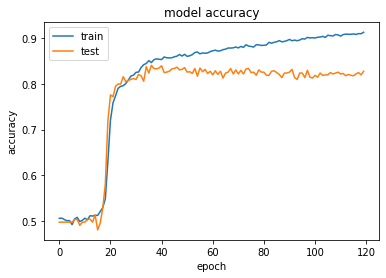

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
model.save('brandnewmodel.h5')

In [102]:
model.load_weights('chatbot_10.h5')

In [103]:
pred_results = model.predict(([inputs_test, queries_test]))

In [104]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [105]:
pred_results.shape[0]

1000

In [106]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [107]:
test_data[0][2]

'no'

In [108]:
pred_results[0]

array([5.6906323e-14, 5.5444087e-14, 5.7849457e-14, 5.3208103e-14,
       6.1402157e-14, 5.4011381e-14, 9.9972337e-01, 6.5257363e-14,
       5.5710580e-14, 5.3492204e-14, 5.5344767e-14, 5.9928089e-14,
       5.9666451e-14, 6.2852745e-14, 4.7628341e-14, 6.1548721e-14,
       5.2162844e-14, 5.4474047e-14, 4.9623598e-14, 2.7658895e-04,
       5.7422701e-14, 5.4287968e-14, 6.0373690e-14, 5.7739004e-14,
       5.4291698e-14, 5.7451846e-14, 5.6180521e-14, 5.9328946e-14,
       4.7667968e-14, 5.7854315e-14, 6.1993372e-14, 5.1244934e-14,
       4.9404684e-14, 5.6873343e-14, 6.2960250e-14, 6.8127443e-14,
       5.0650619e-14, 5.7325963e-14], dtype=float32)

In [109]:
val_max = np.argmax(pred_results[0])

In [110]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [111]:
k

'up'

In [112]:
tokenizer.word_index.items()

dict_items([('john', 1), ('yes', 2), ('office', 3), ('?', 4), ('moved', 5), ('up', 6), ('mary', 7), ('back', 8), ('dropped', 9), ('in', 10), ('garden', 11), ('.', 12), ('got', 13), ('travelled', 14), ('left', 15), ('apple', 16), ('is', 17), ('picked', 18), ('journeyed', 19), ('football', 20), ('kitchen', 21), ('milk', 22), ('there', 23), ('down', 24), ('discarded', 25), ('daniel', 26), ('grabbed', 27), ('to', 28), ('the', 29), ('went', 30), ('took', 31), ('sandra', 32), ('bathroom', 33), ('no', 34), ('put', 35), ('bedroom', 36), ('hallway', 37)])